In [1]:
# import os
# os.getcwd()
# os.chdir('/home/chtung/project_MC')

import numpy as np
import time
from tqdm import tqdm, trange
from WLM import WLChain
import matplotlib.pyplot as plt
from scipy.io import savemat, loadmat

<Figure size 1152x1152 with 0 Axes>

In [2]:
## Chain parameters
# Coordinate of C atoms in each unit
# unit_C = load('b_c.dat')';
unit_C = np.zeros((3,1))

# Degree of polymerization
N_backbone = 5000

# Chain stiffness (placeholder)
a_backbone = 1

# Unit persistence
lambda_backbone = 1

In [3]:
def f_lb_theta(theta):
    return -1/np.log(theta)

def f_theta_lb(lb):
    return np.exp(-1/lb)

def f_lb_a(a):
    L_a = 1-np.cosh(a)/np.sinh(a)
    return 1/1-L_a

In [4]:
def grid_coords(grid):
    if grid=='SC':
        # 6 orientations following the arrangement of standard dice
        # 1/6 for +x/-x; 2/5 for +y/-y; 3/4 for +z/-z
        r_n = np.array([[1,0,0],[0,1,0],[0,0,1],[0,0,-1],[0,-1,0],[-1,0,0]])
        r_opp = np.array([5,4,3,2,1,0])
    
    if grid=='RB':
        # rhombic dodecahedron
        r_n = np.array([[0,1,1],[0,-1,-1],[0,1,-1],[0,-1,1],
                        [1,0,1],[-1,0,-1],[1,0,-1],[-1,0,1],
                        [1,1,0],[-1,-1,0],[1,-1,0],[-1,1,0]])/np.sqrt(2)
        r_opp = np.array([1,0,3,2,
                          5,4,7,6,
                          9,8,11,10])
        
    if grid=='RT':
        phi = (1+np.sqrt(5))/2
        # rhombic triacontahedron
        r_n = np.array([
                       [phi,0,0],[0,phi,0],[0,0,phi],
                       [-phi,0,0],[0,-phi,0],[0,0,-phi],
                       [1/2,phi/2,phi**2/2],[phi**2/2,1/2,phi/2],[phi/2,phi**2/2,1/2],
                       [-1/2,phi/2,phi**2/2],[-phi**2/2,1/2,phi/2],[-phi/2,phi**2/2,1/2],
                       [1/2,-phi/2,phi**2/2],[phi**2/2,-1/2,phi/2],[phi/2,-phi**2/2,1/2],
                       [1/2,phi/2,-phi**2/2],[phi**2/2,1/2,-phi/2],[phi/2,phi**2/2,-1/2],
                       [-1/2,-phi/2,phi**2/2],[-phi**2/2,-1/2,phi/2],[-phi/2,-phi**2/2,1/2],
                       [1/2,-phi/2,-phi**2/2],[phi**2/2,-1/2,-phi/2],[phi/2,-phi**2/2,-1/2],
                       [-1/2,phi/2,-phi**2/2],[-phi**2/2,1/2,-phi/2],[-phi/2,phi**2/2,-1/2],
                       [-1/2,-phi/2,-phi**2/2],[-phi**2/2,-1/2,-phi/2],[-phi/2,-phi**2/2,-1/2]
                       ])
        r_n = np.array([points/np.sqrt(np.sum(points**2)) for points in r_n])
        r_opp = np.array([3,4,5,
                          0,1,2,
                          27,28,29,
                          21,22,23,
                          24,25,26,
                          18,19,20,
                          15,16,17,
                          9,10,11,
                          12,13,14,
                          6,7,8])
        
    return r_n, r_opp

In [5]:
def kappa_eff(l_p, grid, nonreverse=True):
    r_n, _ = grid_coords(grid)
    cos_i1 = r_n@r_n[0].T
    theta_i1 = np.arccos(cos_i1)

    def f_average(x, kappa):
        # x(theta) is a fumction of theta
        x_ave = np.sum(x*np.exp(-kappa/2*theta_i1**2))/np.sum(np.exp(-kappa/2*theta_i1**2))
        return x_ave

    def f_average_nonrev(x, kappa):
        # x(theta) is a fumction of theta
        x_ave = np.sum((x*np.exp(-kappa/2*theta_i1**2))[cos_i1>-1])/np.sum(np.exp(-kappa/2*theta_i1**2)[cos_i1>-1])
        return x_ave
    
    # get the relation between bending energy and chain persistence
    kappa_list = np.logspace(-2,2,200)
    if nonreverse:
        f_ave = f_average_nonrev
    else:
        f_ave = f_average

    cos_ave = np.array([f_ave(cos_i1, k) for k in kappa_list])
    sigma = 1e-18
    lp_ave_list = -1/(np.log(cos_ave)-sigma)

    # obtain the corresponding kappa_eff from interpolation
    i_finite = np.isfinite(lp_ave_list)
    # f_interp = interpolate.PchipInterpolator(lp_ave_list, kappa_list)
    # kap_eff = f_interp(l_p)
    kap_eff = np.interp(l_p, lp_ave_list[i_finite], kappa_list[i_finite])

    return kap_eff

def lp_kappa(kappa, grid, nonreverse=True):
    r_n, _ = grid_coords(grid)
    cos_i1 = r_n@r_n[0].T
    theta_i1 = np.arccos(cos_i1)

    def f_average(x, kappa):
        # x(theta) is a fumction of theta
        x_ave = np.sum(x*np.exp(-kappa/2*theta_i1**2))/np.sum(np.exp(-kappa/2*theta_i1**2))
        return x_ave

    def f_average_nonrev(x, kappa):
        # x(theta) is a fumction of theta
        x_ave = np.sum((x*np.exp(-kappa/2*theta_i1**2))[cos_i1>-1])/np.sum(np.exp(-kappa/2*theta_i1**2)[cos_i1>-1])
        return x_ave
    
    # get the relation between bending energy and chain persistence
    kappa_list = np.logspace(-2,2,200)
    if nonreverse:
        f_ave = f_average_nonrev
    else:
        f_ave = f_average

    sigma = 1e-18

    # obtain the corresponding kappa_eff from interpolation
    lp_kappa = -1/(np.log(f_ave(cos_i1, kappa))-sigma)

    return lp_kappa


In [6]:
def plot_CC(Cc, ax, show_axes=1, end=1, axeslabel='off'):
    """
    Plot polymer chain.
    
    Args:
        filename: str
    """
            
    ax.plot(Cc[0,:],Cc[1,:],Cc[2,:], 
            '-', color='#D00000', linewidth=2, alpha = 0.75)
    # ax.plot(Cc[0,:],Cc[1,:],Cc[2,:], 
    #         'o', markeredgecolor='#800000', markerfacecolor='#D00000')

    # plot chain end
    if end==1:
        ax.plot(Cc[0,0],Cc[1,0],Cc[2,0], 
                    'o', markeredgecolor='#000080', markerfacecolor='#0000D0')
        ax.plot(Cc[0,-1],Cc[1,-1],Cc[2,-1], 
                    'o', markeredgecolor='#008000', markerfacecolor='#00D000')

    #CM = np.mean(Cc_backbone,axis=1)
    CT = np.array([np.max(Cc[0,:])+np.min(Cc[0,:]),
                    np.max(Cc[1,:])+np.min(Cc[1,:]),
                    np.max(Cc[2,:])+np.min(Cc[2,:])])/2
    d_box = np.max([np.max(Cc[0,:])-np.min(Cc[0,:]),
                    np.max(Cc[1,:])-np.min(Cc[1,:]),
                    np.max(Cc[2,:])-np.min(Cc[2,:])])

    if axeslabel=='on':
        ax.set_xlabel(r'$x$')
        ax.set_ylabel(r'$y$')
        ax.set_zlabel(r'$z$')

    if show_axes==0:
        ax.set_xticklabels([])
        ax.set_yticklabels([])
        ax.set_zticklabels([])
        #ax.axis('off')

    ax.set_xlim([CT[0]-d_box/2, CT[0]+d_box/2])
    ax.set_ylim([CT[1]-d_box/2, CT[1]+d_box/2])
    ax.set_zlim([CT[2]-d_box/2, CT[2]+d_box/2])
    ax.set_box_aspect([1,1,1])

In [7]:
def plot_chain_params(kappa, epsilon, chain, fig, loc, rows):
    print(f"kappa = {kappa}")
    # call class
    chain01 = chain
    chain01.d_exc = 1

    chain01.apply_SA = 0
    chain01.d_exc = 0.1
    chain01.f = 0.0
    # Chain stiffness
    chain01.epsilon = epsilon
    chain01.kappa = kappa

    chain_Cc_list = []
    for grid in ['SC','RB','RT']:
        chain01.grid = grid
        print(grid)
        # print(f"l_p = {chain01.kappa}")
        # print(f"l_p = {kappa_eff(chain01.kappa,grid)}")
        chain01.original_kappa = True
        chain01.chain_grid()
        filename_chain = './test.png'
        # chain01.plot(filename=filename_chain, show_axes=0, save=1, end=1, fig = plt.figure(figsize=(4, 4),dpi=192))
        chain_Cc_list.append(chain01.Cc)
        
    for i in range(3):
        ax = fig.add_subplot(rows,4,i+1+4*loc, projection='3d')
        chain_Cc = chain_Cc_list[i]
        plot_CC(chain_Cc, ax, show_axes=1, end=1, axeslabel='off')

    # plot Rayleigh chain
    chain01.a = kappa
    chain01.chain()

    ax = fig.add_subplot(rows,4,4+4*loc, projection='3d')
    plot_CC(chain01.Cc, ax, show_axes=1, end=1, axeslabel='off')
    plt.tight_layout()


[5, 0]
kappa = 5
SC
5
5
5
5
5
5
RB
5
5
5
5
5
5
5
5
5
5
5
5
RT
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
[45, 0]
kappa = 45
SC
45
45
45
45
45
45
RB
45
45
45
45
45
45
45
45
45
45
45
45
RT
45
45
45
45
45
45
45
45
45
45
45
45
45
45
45
45
45
45
45
45
45
45
45
45
45
45
45
45
45
45
[500, 0]
kappa = 500
SC
500
500
500
500
500
500
RB
500
500
500
500
500
500
500
500
500
500
500
500
RT
500
500
500
500
500
500
500
500
500
500
500
500
500
500
500
500
500
500
500
500
500
500
500
500
500
500
500
500
500
500


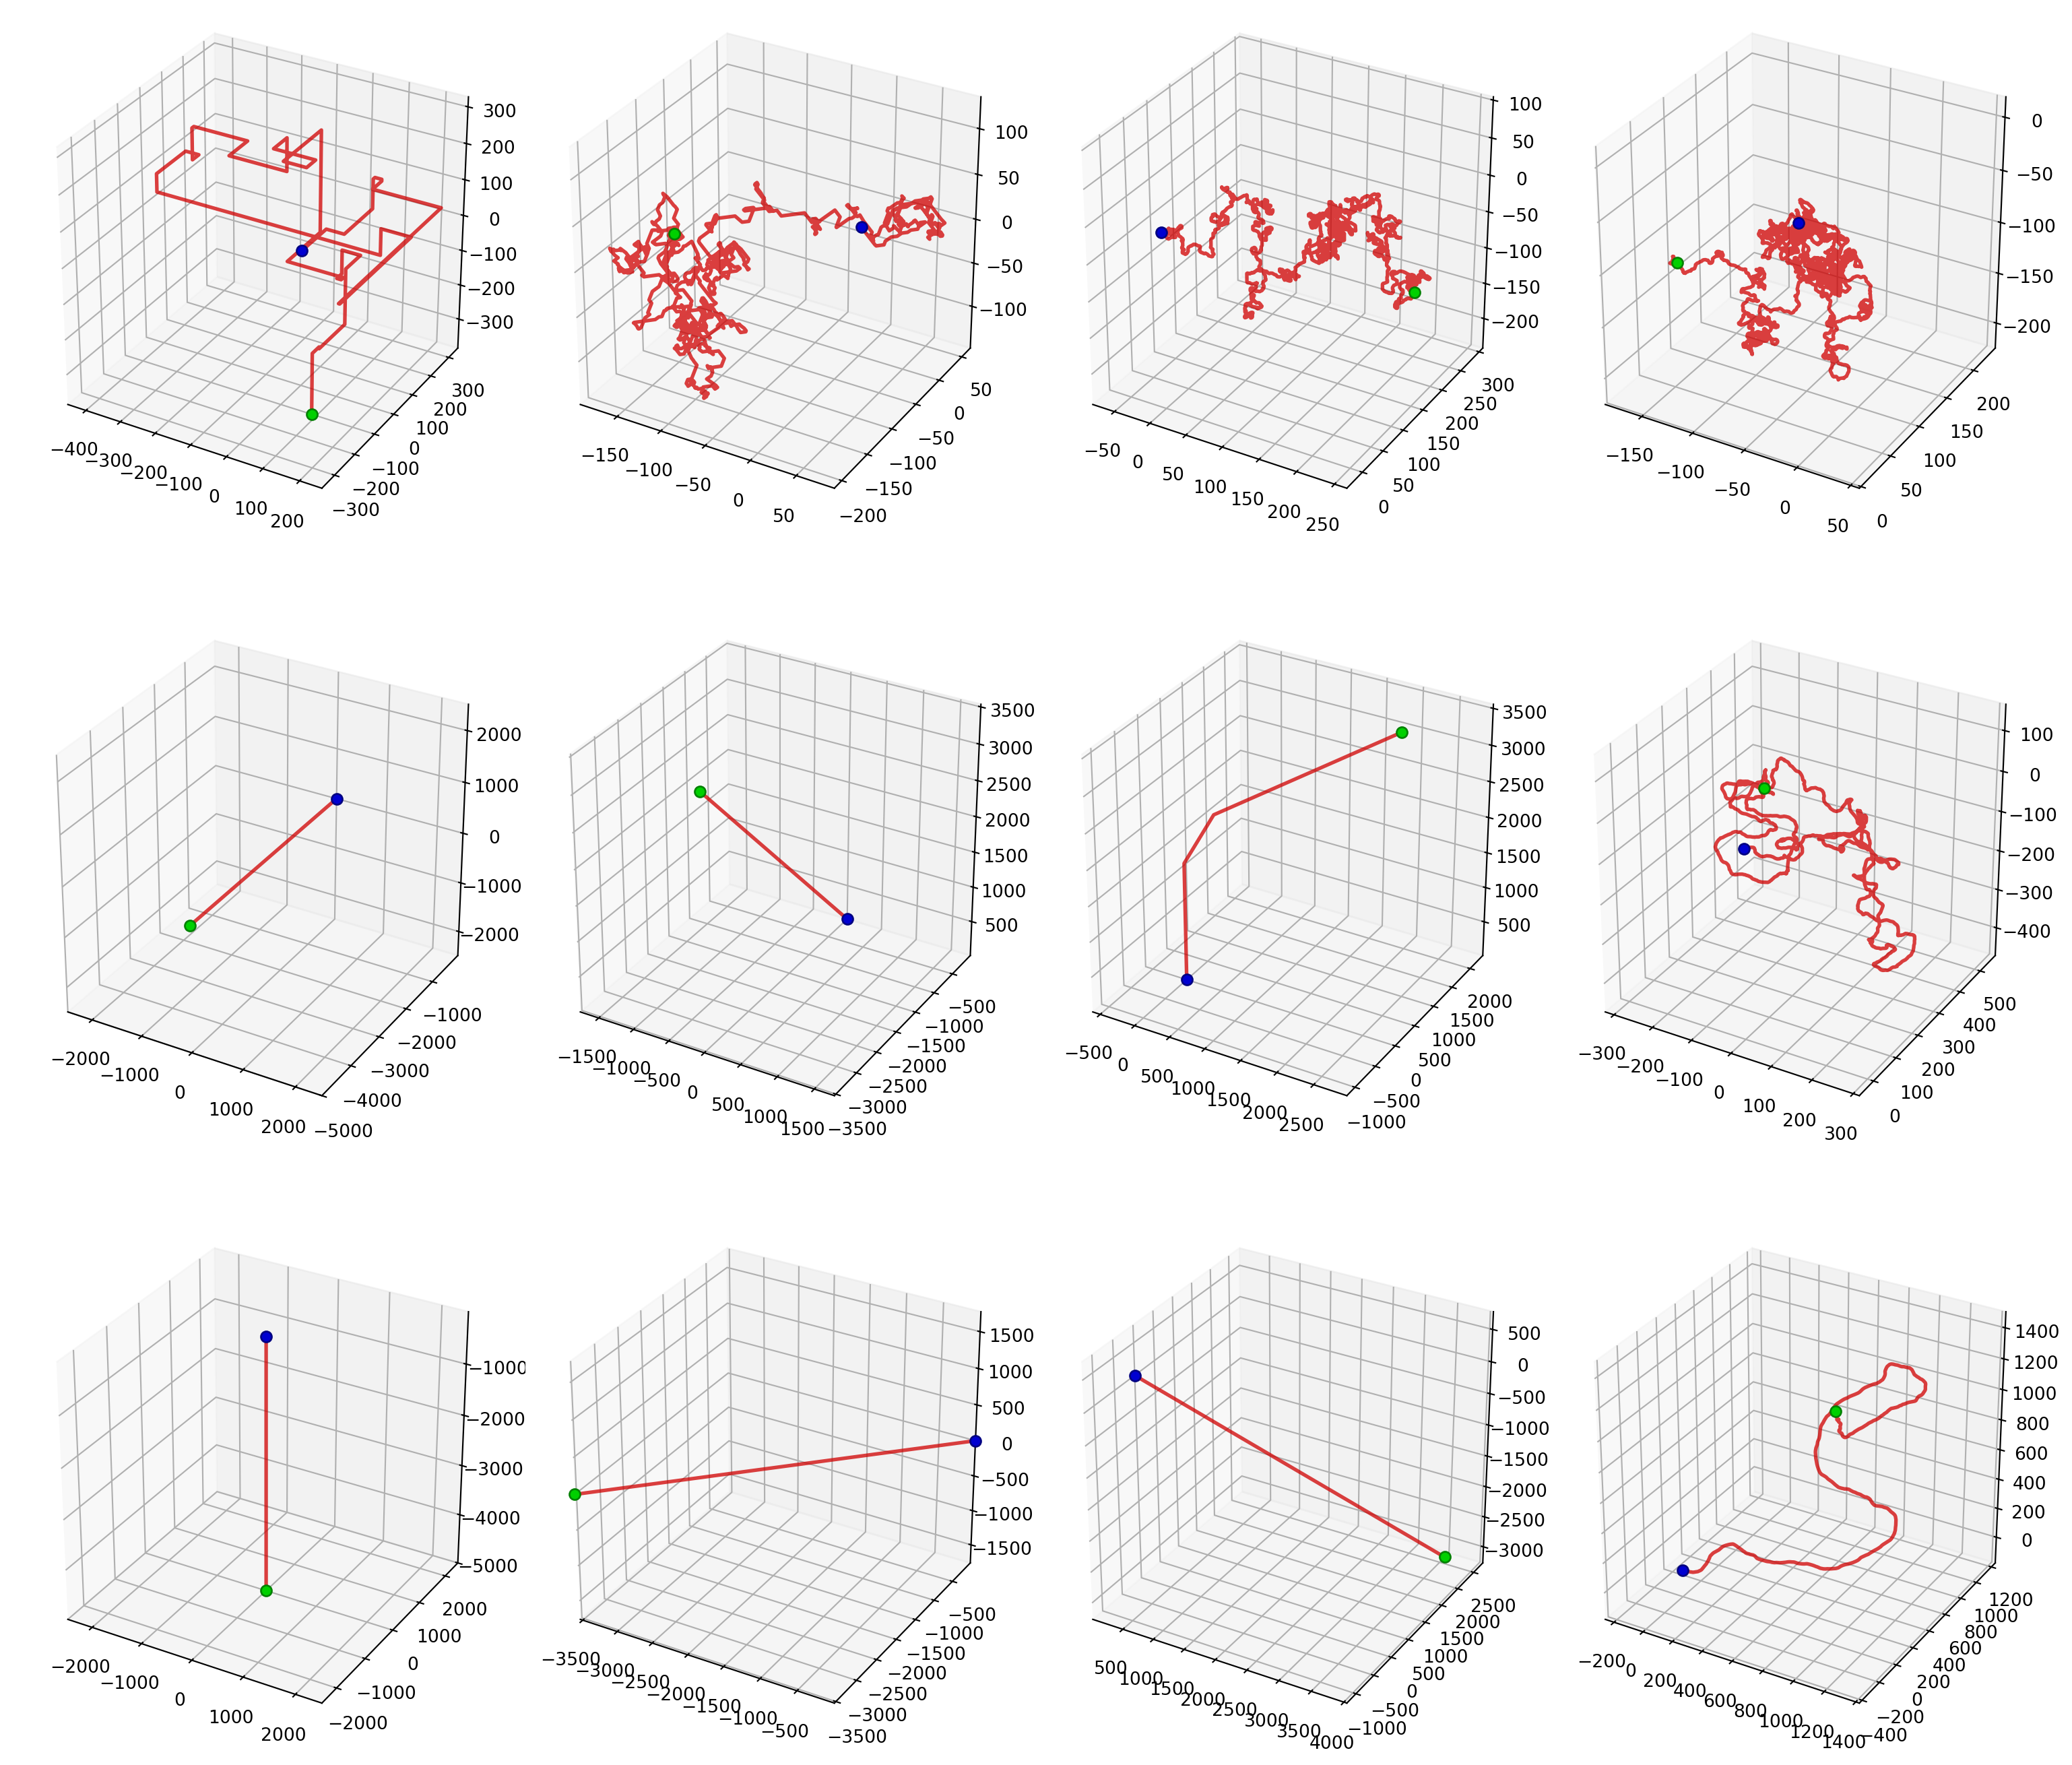

In [10]:
kappa_list = np.array([5,50,500])
epsilon_list = [0]

parameters_list = []
for kappa in kappa_list:
    for epsilon in epsilon_list:
        parameters_list.append([kappa, epsilon])

# Call WLChain class
chain = WLChain(N_backbone,a_backbone,lambda_backbone,unit_C)
chain.apply_SA = 1
chain.d_exc = 0.1
chain.f = 0.0

fig = plt.figure(figsize=(16, 16),dpi=192)

for j, params in enumerate(parameters_list):
    kappa = params[0]
    epsilon = params[1]
    print(params)
    plot_chain_params(kappa, epsilon, chain, fig, loc=j, rows=len(kappa_list))